## ImageBasedDataMining.ipynb
‹ ImageBasedDataMining.ipynb › Copyright (C) ‹ 2019 › ‹ Andrew Green - andrew.green-2@manchester.ac.uk › This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

In [1]:
"""
|   Date     |   Who   |   Note                                       |
| 20190201   |   afg   |   First version, adapted from MadagaSKA code |
| 20190206   |   afg   |   Finished binary IBDM, just needs plotting  |
| 20190208   |   afg   |   Update paths to work with docker container |
""";

This notebook shows how to do image based data mining against a binary outcome. The outcome could be whatever you like, provided it is binary; some examples include overall survival, locoregional failure and feeding tube insertion

In [32]:
## Import libraries we want and set up the notebook
import os
import time
import os.path
import numpy as np
try:
    from tqdm import tqdm
    haveTQDM = True
except:
    haveTQDM = False
import SimpleITK as sitk
import matplotlib.pyplot as plt

%matplotlib inline

We will use pandas to load a csv file of the data. Pandas is very powerful - here we will be using only its most basic functions.

In [33]:
import pandas as pd

clinicalDataPath = "/data/clinicalData.csv"

clinicalData = pd.read_csv(clinicalDataPath)



In the clinical data is a column recording what type of treatment a patient had. We can look at that column by indexing the dataframe with the column heading like this:

In [34]:
clinicalData["Oncologic Treatment Summary"]

0                                                CCRT
1                                                CCRT
2                                                CCRT
3                                                CCRT
4                                                 ERT
5                                                CCRT
6                  Induction CMT --> CCRT --> Surgery
7                                                 ERT
8                   Induction CMT --> ERT --> Surgery
9                                                CCRT
10                 Induction CMT --> CCRT --> Surgery
11                                    ERT --> Surgery
12                                                ERT
13                                   Surgery --> CCRT
14                              Induction CMT --> ERT
15                                    ERT --> Surgery
16                                    ERT --> Surgery
17                             Induction CMT --> CCRT
18                          

There are a lot of acronyms going on in this data, the most important are:

CMT  = Chemotherapy
ERT  = External beam radiotherapy
CCRT = Concurrent Chemo-radiotherapy

Other information includes what type of treatment was used when in a patient's pathway, for eaxmple:

`Surgery --> CMT --> CCRT + Cetuximab`

means a patient had surgery, then chemotherapy, then concurrent chemo-radiotherapy with an immunotherapy drug called Cetuximab.

The type of treatment a patient recieved is very important, because it affects how they respond. To remove potential confounding effects in our image based data mining, we would like to have all the patients be on as similar a course of treatment as possible. 

As a first set of patients to try, lets only take patients who started their treatment with CCRT. We will allow patients who had surgery after radiotherapy, because that shouldn't affect their response to the radiation. If we were being really strict, we could also exclude these patients.

We can reduce our dataset using some pandas indexing tricks

In [5]:
ccrtOnlyPatients = clinicalData[(clinicalData["Oncologic Treatment Summary"].str.contains('^CCRT', regex=True)) & (clinicalData["Oncologic Treatment Summary"].str.contains('\+', regex=True) == False)]
len(ccrtOnlyPatients["Oncologic Treatment Summary"])

60

To explain what is going on here:

- `[]` indexes the dataframe, getting values out of it. We can do this with a boolean mask 
- `(clinicalData["Oncologic Treatment Summary"].str.contains('^CCRT', regex=True))` asks "Does the value in this cell start with CCRT?" It says True where this is the case
- `(clinicalData["Oncologic Treatment Summary"].str.contains('\+', regex=True) == False)` Asks "Does the value in this cell not contain a + symbol?
- The `&` symbol combines the two logical statements into a boolean mask
- We end up with patients who have started their treatment with CCRT, and who didn't get immunotherapy

This reduces our original dataset quite a lot, now we only have 60 patients. After we've done some work here, maybe it would be a good idea to relax some of these requirements. You can choose how to relax them by changing the logical statements in this indexing.

So now we have our cohort, selected based on their radiotherapy. we need to check a few other things are in order before we continue:

- Do all the patients get the same overall dose?
- Do all the patients get the same number of fractions?
- Do we have all the outcome data we want to be able to do our datamining on these patients?

The total dose recieved by the patient is in our database in the column "RT Total Dose (Gy)". We can go ahead and histogram this for the patients we have selected.

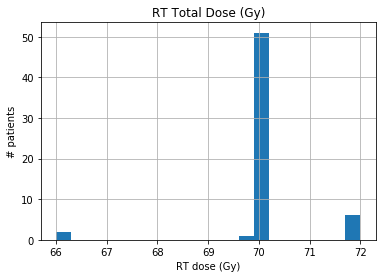

In [6]:
doseHistogram = ccrtOnlyPatients.hist(column="RT Total Dose (Gy)", bins=20) ## you can adjust many bits of this plot!
plt.xlabel("RT dose (Gy)");
plt.ylabel("# patients");

As you can see, most patients got a dose of 70 Gy, but there were a few who got higher or lower doses.

Let's look at the dose per fraction next by indexing it to get a table

In [7]:
ccrtOnlyPatients[["Dose/Fraction (Gy/fx)", "RT Total Dose (Gy)", "Number of Fractions"]]


,Dose/Fraction (Gy/fx),RT Total Dose (Gy),Number of Fractions
0,2.12,69.96,33
1,2.12,70.00,33
2,2.12,70.00,33
3,2,66.00,33
5,2,70.00,35
9,2.12,70.00,33
18,2.12,70.00,33
21,2.12,70.00,33
35,2.12,70.00,33
36,2.12,70.00,33


From this, we can see that all of the patients who got 72 Gy had a non-standard fractionation where they recieved some boost in the last couple of weeks of treatment. These patients always had their treatment in 40 fractions.

For simplicity, we will exclude these patients. 

In [8]:
selectedPatients = ccrtOnlyPatients[ccrtOnlyPatients["Number of Fractions"].astype(int) < 40]
len(selectedPatients["Number of Fractions"])

54

Now we have a nice clean dataset where all our patients got nice easy to manipulate fractionation, we need to adjust their doses to take account of the different doses per fraction.

We have to do this because of how radiation works: 70 Gy in 33 fractions is a different biologically effective dose than 70 Gy in 35 fractions. If we don't adjust for this, then our results will probably not make any sense.

Different fractionations have diferent effects because of the different amount of time normal tissue has to recover. Before we can mine data with different fractionations, we need to standardize somehow. This is usually done with a biologically equivalent dose (BED) calculation, or an equivalent dose @ 2 Gy/fraction (EQD2) calculation. Here we will do a simple BED calculation, whereby we just multiply the real dose by a factor to take account of the differences in fractionation.

Also, whether we want to look at 'acute effects' (i.e. things that happen soon) or 'late effects' (i.e. things that happen after a few weeks/months) has a bearing on what we need to do here. The way these differences come into the BED calculation is in an $\alpha/\beta$ ratio. A ratio of $\alpha/\beta$ = 3.0 is usual when considering late effects.

Now we have to choose an endpoint. Let's look at feeding tube insertion, which I think is probably an early effect. That means we need an $\alpha/\beta$ of 10.

In [9]:
def calculateBEDCorrection(df, early=True):
    earlyAlphaBeta = 10.0
    lateAlphaBeta  = 03.0
#     fractionDoses = df["Dose/Fraction (Gy/fx)"].astype(float)
    
    if early:
        df = df.assign(BEDfactor = lambda d : 1.0 + d["Dose/Fraction (Gy/fx)"].astype(float)/earlyAlphaBeta)
    else:
        df = df.assign(BEDfactor = lambda d : 1.0 + d["Dose/Fraction (Gy/fx)"].astype(float)/lateAlphaBeta)
    return df

selectedPatients = calculateBEDCorrection(selectedPatients)

selectedPatients

,ID,Sex,Age,Date of Birth,Diag,Site,Histology,Grade,T,N,...,Post-RT L3 Skeletal Muscle Index (cm2/m2),Pre-RT L3 Adiposity Index (cm2/m2),Post-RT L3 Adiposity Index (cm2/m2),Pre-RT CT-derived lean body mass (kg),Post-RT CT-derived lean body mass (kg),Pre-RT CT-derived fat body mass (kg),Post-RT CT-derived fat body mass (kg),PreRT Skeletal Muscle status,PostRT Skeletal Muscle status,BEDfactor
0,HNSCC-01-0001,Female,54,17/02/1944,CA soft palate,Oropharynx,SCC,moderately to poorly diff.,2,2c,...,23.254397,43.492939,24.751553,28.793945,25.867339,16.386422,14.151560,SM depleted,SM depleted,1.212
1,HNSCC-01-0002,Female,56,27/05/1945,NPC,Nasopharynx,SCC,moderately diff.,4,2,...,36.556084,93.099268,77.029684,36.258777,36.280183,21.974862,20.115046,SM depleted,SM depleted,1.212
2,HNSCC-01-0003,Male,48,06/09/1953,CA tonsil,Oropharynx,SCC,moderately diff.,2,2b,...,36.556084,93.099268,77.029684,36.258777,36.280183,21.974862,20.115046,SM depleted,SM depleted,1.212
3,HNSCC-01-0004,Male,65,13/05/1931,CA tonsil,Oropharynx,SCC,poorly diff.,4a,2c,...,59.719444,78.759400,45.277003,67.503425,62.824526,21.680734,17.225138,SM not depleted,SM not depleted,1.200
5,HNSCC-01-0006,Male,62,11/09/1934,CUP,CUP,SCC,moderately diff.,0,2a,...,36.347750,133.398240,47.252075,59.264893,39.454495,28.358349,17.277798,SM not depleted,SM depleted,1.200
9,HNSCC-01-0010,Male,63,13/06/1933,CA tonsil,Oropharynx,SCC,moderately to poorly diff.,4,2b,...,44.027448,34.377174,20.009673,45.748073,45.362752,15.496330,13.700734,SM depleted,SM depleted,1.212
18,HNSCC-01-0019,Male,61,20/07/1936,CA tonsil,Oropharynx,SCC,moderately to poorly diff.,4a,3,...,44.027448,34.377174,20.009673,45.748073,45.362752,15.496330,13.700734,SM depleted,SM depleted,1.212
21,HNSCC-01-0022,Male,64,10/10/1933,CA tonsil,Oropharynx,SCC,poorly diff.,2,2b,...,44.757360,219.532423,147.013145,62.127278,43.283242,36.760917,28.317248,SM depleted,SM depleted,1.212
35,HNSCC-01-0036,Male,66,20/01/1932,CA buccal mucosa,Oral cavity,SCC,poorly diff.,1,2b,...,44.757360,219.532423,147.013145,62.127278,43.283242,36.760917,28.317248,SM depleted,SM depleted,1.212
36,HNSCC-01-0037,Male,52,21/11/1945,CA larynx,Glottis,SCC,poorly diff.,4a,0,...,51.596246,180.078939,89.891326,61.576820,50.793945,33.057982,22.111009,SM not depleted,SM depleted,1.212


Now we have our BED correction, we can start loading data ready to do mining. We will load each image using SimpleITK, convert it to a numpy array and put it into a bit numpy array. We will concurrently load the binary status from the clinical data as well and put that into a numpy array.

In the next cell, we will load all our data. Note that we pre-allocate the numpy array we will use to hold the data - this is a performance optimisation to make loading the data a bit quicker.

In [10]:
dosesPath = "/data/registeredDoses"
availableDoses = ["HNSCC-01-{0}".format(a.split('.')[0]) for a in os.listdir(dosesPath)]

availablePatientsMask = selectedPatients['ID'].isin(availableDoses)
probeDose = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0:04d}.nii".format(int(2)))))

availablePatients = selectedPatients.loc[availablePatientsMask]
len(availablePatients)



doseArray = np.zeros((*probeDose.shape, len(availablePatients)))
statusArray = np.zeros((len(availablePatients),1))

print(doseArray.shape)


n = 0
for idx, pt in availablePatients.iterrows():
    doseArray[...,n] = pt.BEDfactor * sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(dosesPath, "{0}.nii".format(pt.ID.split("-")[-1]))))
    statusArray[n] = int(pt.Status == "Dead")
    n += 1
    

(123, 128, 128, 48)


Now we should have the dose and status data loaded, so we can start doing data mining!

Here we will defien a function to do binary data mining using a Student t-Test approach. This involves calculating the meand and variance in every voxel for each status group, then using that on a per-voxel basis to caluclate the per-voxel value of t. 

In [18]:
def imagesTTest(doseData, statuses, mask=None):
    """
    Calculate a per-voxel t statistic between two images. Uses Welford's method to calculate mean and variance. 
    NB: there is a tricky little bit at the end. Welford's method requires dividing by N to get variance, the T-test 
    also requires dividing by N, so we just divide by N^2.
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - statuses: the outcome labels. 1 indicates an event, 0 indicates no event
    Returns:
        - Tvalues: an array of the same size as one of the images which contains the per-voxel t values
    """
    noEventMean = np.zeros_like(doseData[...,0])
    eventMean = np.zeros_like(doseData[...,0])# + np.finfo(float).eps

    noEventStd = np.zeros_like(doseData[...,0])
    eventStd = np.zeros_like(doseData[...,0])# + np.finfo(float).eps

    eventCount = 0
    nonEventCount = 0
    for n, stat in enumerate(statuses):
        if stat == 1 and eventCount == 0:
            eventCount += 1.0
            eventMean = doseData[...,n]
        elif stat == 1:
            eventCount += 1.0
            om = eventMean.copy()
            eventMean = om + (doseData[...,n] - om)/eventCount
            eventStd = eventStd + ((doseData[...,n] - om)*(doseData[...,n] - eventMean))


        elif stat == 0 and nonEventCount == 0:
            nonEventCount += 1.0
            noEventMean = doseData[...,n]
        elif stat == 0:
            nonEventCount += 1.0
            om = noEventMean.copy()
            noEventMean = om + (doseData[...,n] - om)/nonEventCount
            noEventStd = noEventStd + ((doseData[...,n] - om)*(doseData[...,n] - noEventMean))

    eventStd /= (eventCount**2)      
    noEventStd /= (nonEventCount**2)

    Tvalues = np.divide((eventMean - noEventMean), np.sqrt(eventStd + noEventStd))
    if mask is not None:
        Tvalues *= mask.astype(np.float64)
    return Tvalues

This function is pretty big, so let's look at what it's doing!

We first create four working arrays, one each for the mean and standard deviation in each group. These arrays are initially filled with zeros.

After that, we use a numerically stable method of calculation for the mean and variance of data called Welford's method. The final step converts the variance to standard deviation, then calculates the pixelwise t-value from it and the mean. We then return the t values.

I have included an optional argument, the mask to use durig the calculation. At themoment, it does nothing more than multiply the t-map at the end of the calculation, but it would be nice to be able to skip calculation outside the mask, because the t-map doesn't make sense there anyway.

Note that the `...` syntax in numpy just means work over all the other axes!

---

We can now use this function with the data we have loaded to get a map of t values, which tells us how the dose affects outcome in different regions of the anatomy.

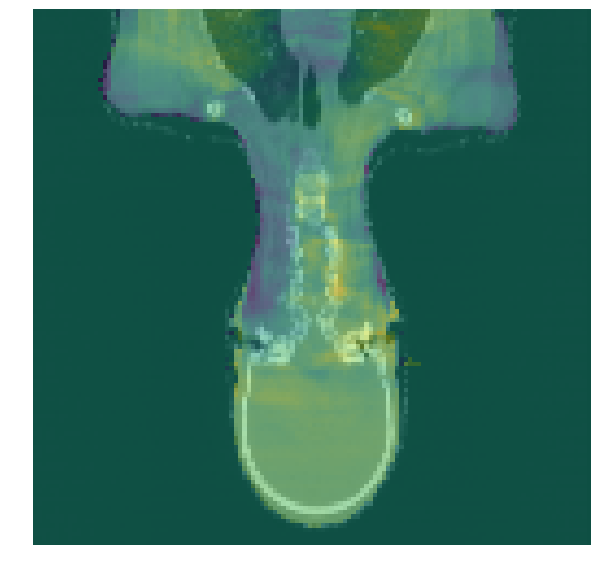

In [35]:
mask = sitk.GetArrayFromImage(sitk.ReadImage("/data/0002_mask_ds.nii")).astype(np.int16)

tMap = imagesTTest(doseArray, statusArray, mask=mask)

referenceAnatomy = sitk.GetArrayFromImage(sitk.ReadImage("/data/downsampledCTs/0002.nii"))

fig = plt.figure(figsize=(10,10))
anatomy = plt.imshow(referenceAnatomy[:,64,...], cmap='Greys_r')
tMapOverlay = plt.imshow(tMap[:,64,...], alpha=0.5)
_ = plt.axis('off')

Now you should have an image of the patient anatomy overlaid with a t-map indicating where dose is having an effect on outcome.

This is cool, but it isn't the whole story! We need to assess the statistical significance of the values in the t-map. Because there are so many voxels in the image, we can't do this analytically. This is known as a multiple comparisons problem.

The standard way to assess significance in image based data mining is to do a permutation test. In this, we randomly shuffle the labels used to calculate the t-map, and compare the resulting permuted t-map to the original. Anywhere where the 'true' t-map is always more extreme than the permuted t-map is a statistically significant region.

Usually, we record a single 'summary statistic' from the permutations. Here we will use the simplest summary statistic possible: the most extreme value.

We can write two functions to help us do a permutation test: one to calculate the t-map for a given permutation, and another to organise the information coming from the permutations.

In [23]:
def doPermutation(doseData, statuses, mask=None):
    """
    Permute the statuses and return the maximum t value for this permutation
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - statuses: the outcome labels. 1 indicates an event, 0 indicates no event. These will be permuted in this function to 
                    assess the null hypothesis of no dose interaction
    Returns:
        - (tMin, tMax): the extreme values of the whole t-value map for this permutation
    """
    pstatuses = np.random.permutation(statuses)
    permT = imagesTTest(doseData, pstatuses, mask=mask)
    return (np.min(permT), np.max(permT))

This function is pretty simple, it uses a numpy function to randomly permute the status labels, then re-calculates the t-map.

The returned values from this function are the smallest and largest values. Usually these will be negative and positive respectively, indicating a different effect of the dose on outcome.

In [24]:
def permutationTest(doseData, statuses, nperm=1000, mask=None):
    """
    Perform a permutation test to get the global p-value and t-thresholds
    Inputs:
        - doseData: the dose data, should be structured such that the number of patients in it is along the last axis
        - statuses: the outcome labels. 1 indicates an event, 0 indicates no event.
        - nperm: The number of permutations to calculate. Defaults to 1000 which is the minimum for reasonable accuracy
    Returns:
        - globalPNeg: the global significance of the test for negative t-values
        - globalPPos: the global significance of the test for positive t-values
        - tThreshNeg: the list of minT from all the permutations, use it to set a significance threshold.
        - tThreshPos: the list of maxT from all the permutations, use it to set a significance threshold.
    """
    tthresh = []
    gtCount = 0
    ltCount = 0
    trueT = imagesTTest(doseData, statuses, mask=mask)
    trueMaxT = np.max(trueT)
    trueMinT = np.min(trueT)
    if haveTQDM:
        for perm in tqdm(range(nperm)):
            tthresh.append(doPermutation(doseData, statuses, mask=mask))
            if tthresh[-1][1] > trueMaxT:
                gtCount += 1.0
            if tthresh[-1][0] < trueMinT:
                ltCount += 1.0
    else:
        for perm in range(nperm):
            tthresh.append(doPermutation(doseData, statuses, mask=mask))
            if tthresh[-1][1] > trueMaxT:
                gtCount += 1.0
            if tthresh[-1][0] < trueMinT:
                ltCount += 1.0
    
    globalpPos = gtCount / float(nperm)
    globalpNeg = ltCount / float(nperm)
    tthresh = np.array(tthresh)
    return (globalpNeg, globalpPos, sorted(tthresh[:,0]), sorted(tthresh[:,1]))

This function organises the data returned from the doPermutation function, and returns us some global summary statistics, as well as an ordered array of maximum and minimum t values from the permutations, that can be used to place significance thresholds on the t-map from the true status labels.

The nperm argument to this function is important. It is the number of permutations we will perform - this impacts the minimum p-value we can see (1/nperm) but more importantly impacts the length of time the analysis takes to run. A standard number of permutations would be 1000, though this might take a while!

Let's apply the permutation test to our data!

*Warning: this cell will take a long time to run! About 6 minutes on my laptop. If you don't have tqdm for a progressbar, have faith that it is working!*

In [26]:
pNeg, pPos, threshNeg, threshPos = permutationTest(doseArray, statusArray, nperm=100, mask=mask)

100%|██████████| 100/100 [06:23<00:00,  3.78s/it]


Now we have what we need to look for a dose sensitive region! To get an idea whether we have anything to look at, we can look at the global p-values. These are contained in the pNeg and pPos variables

In [27]:
print(pNeg, pPos)

0.2 0.38


The usual threshold for saying a result is statstically sgnificant is p=<0.05. Unfortunately, in my example analysis we don't seem to have a globally significant result. Everything below here won't really work properly because there is not significant result in this case, however let's do it anyway so you can see what to do when you mine something else later and get a significant result!

---

We also have our map of T values, and the associated permutation test distribution, so we can plot the regions of significance overlaid on the t-map and CT anatomy. To do this, we use matplotlib's imshow and contourf functions as below

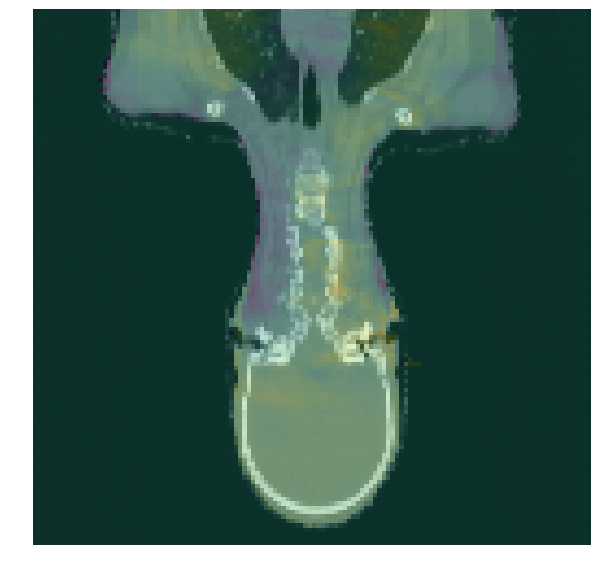

In [39]:
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(111)

# First show the CT
ctImg = ax.imshow(referenceAnatomy[:,64,:], cmap='Greys_r')

# Now add the t-map with some transparency
tmapImg = ax.imshow(tMap[:,64,:], alpha=0.3)

plt.axis('off');

neg_p005 = np.percentile(threshNeg, 0.05)
neg_p010 = np.percentile(threshNeg, 0.10) ## Contour plot needs two levels, so we use p=0.05 & 0.10
pos_p005 = np.percentile(threshPos, 0.95)
pos_p010 = np.percentile(threshPos, 0.9)

## Now do the contourplot at the 95% level for p=0.05
pos_contourplot = plt.contourf(tMap[:,64,:], levels=[pos_p010, pos_p005], colors='r')
neg_contourplot = plt.contourf(tMap[:,64,:], levels=[neg_p005, neg_p010], colors='g')

Now we have a complete pipeline to do image based data mining!

Now use this pipeline to try mining against some of the other outcomes in the clinical data, for example:

- Local/regional failure
- Feeding tube insertion
- Weight loss
- Skeletal muscle index reduction

Have fun!